# Cancer outcome predictions ( 1 year survival) Classification
 Data from github reposite
 https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Training_set_advc.csv
 
 ## About Data

    ID_Patient_Care_Situation: Care situation of a patient during treatment
    Diagnosed_Condition: The diagnosed condition of the patient
    ID_Patient: Patient identifier number
    Treatment_with_drugs: Class of drugs used during treatment
    Survived_1_year: If the patient survived after one year (0 means did not survive; 1 means survived)
    Patient_Age: Age of the patient
    Patient_Body_Mass_Index: A calculated value based on the patient’s weight, height, etc.
    Patient_Smoker: If the patient was a smoker or not
    Patient_Rural_Urban: If the patient stayed in Rural or Urban part of the country

Previous_Condition: Condition of the patient before the start of the treatment ( This variable is splitted into 8 columns - A, B, C, D, E, F, Z and Number_of_prev_cond. A, B, C, D, E, F and Z are the previous conditions of the patient. Suppose for one patient, if the entry in column A is 1, it means that the previous condition of the patient was A. If the patient didn't have that condition, it is 0 and same for other conditions. If a patient has previous condition as A and C , columns A and C will have entries as 1 and 1 respectively while the other column B, D, E, F, Z will have entries 0, 0, 0, 0, 0 respectively. The column Number_of_prev_cond will have entry as 2 i.e. 1 + 0 + 1 + 0 + 0 + 0 + 0 + 0 = 2 in this case. ) 

In [57]:
# import all libs
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from dython.data_utils import split_hist
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder    


from imblearn.over_sampling import SMOTE

from collections import Counter


## Now first we only focused on the training data

In [9]:
# import the csv training data
cancer = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Training_set_advc.csv', index_col = 0)
print(cancer.head())

                           Diagnosed_Condition  Patient_ID Treated_with_drugs  \
ID_Patient_Care_Situation                                                       
16201                                       47        8433                DX2   
9421                                         3        2972                DX6   
16205                                        7        8608                Dx6   
5582                                        31       10074               dx6    
20880                                       43        7462                dx1   

                           Patient_Age  Patient_Body_Mass_Index  \
ID_Patient_Care_Situation                                         
16201                               60                21.655523   
9421                                 2                28.852743   
16205                               20                26.179725   
5582                                 8                22.638945   
20880                         

In [10]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25079 entries, 16201 to 16072
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Diagnosed_Condition       25079 non-null  int64  
 1   Patient_ID                25079 non-null  int64  
 2   Treated_with_drugs        25071 non-null  object 
 3   Patient_Age               25079 non-null  int64  
 4   Patient_Body_Mass_Index   25079 non-null  float64
 5   Patient_Smoker            25079 non-null  object 
 6   Patient_Rural_Urban       25079 non-null  object 
 7   Patient_mental_condition  25079 non-null  object 
 8   A                         23723 non-null  float64
 9   B                         23723 non-null  float64
 10  C                         23723 non-null  float64
 11  D                         23723 non-null  float64
 12  E                         23723 non-null  float64
 13  F                         23723 non-null  float64
 14  Z 

In [11]:
cancer.describe()

,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
count,25079.000000,25079.000000,25079.000000,25079.000000,23723.000000,23723.000000,23723.000000,23723.000000,23723.000000,23723.000000,23723.000000,23723.000000,25079.000000
mean,26.382631,6237.758523,33.193548,23.439952,0.894111,0.136028,0.183409,0.083716,0.396240,0.054420,0.000337,1.748261,0.634316
std,15.096967,3603.338849,19.507617,3.778849,0.307702,0.342826,0.387009,0.276968,0.489126,0.226849,0.018361,0.770324,0.481631
min,0.000000,1.000000,0.000000,1.089300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,3125.000000,16.000000,20.205050,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,26.000000,6228.000000,33.000000,23.369168,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
75%,40.000000,9356.500000,50.000000,26.730785,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000
max,52.000000,12514.000000,142.000000,29.999579,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000


## Cleaning data

In [12]:
# check how many diagnosed conditions and patients are there
print ('Patients', len(np.unique(cancer['Patient_ID'])))
print('Conditions', len(np.unique(cancer['Diagnosed_Condition'])))

Patients 10599
Conditions 53


In [13]:
# Check NA values in each column
cancer.isnull().sum()

Diagnosed_Condition            0
Patient_ID                     0
Treated_with_drugs             8
Patient_Age                    0
Patient_Body_Mass_Index        0
Patient_Smoker                 0
Patient_Rural_Urban            0
Patient_mental_condition       0
A                           1356
B                           1356
C                           1356
D                           1356
E                           1356
F                           1356
Z                           1356
Number_of_prev_cond         1356
Survived_1_year                0
dtype: int64

In [14]:
# see how observations stay if drop NA
# cancer = cancer.dropna()
# cancer.info()

In [15]:
# # check # of diagnosed conditions and patients again after dropna
# print ('Patients', len(np.unique(cancer['Patient_ID'])))
# print('Conditions', len(np.unique(cancer['Diagnosed_Condition'])))

Compared to the original, Patients 10599, Conditions 53. Patient number decreased, not good!

In [16]:
# check if the missing values should all be 0
cancer[cancer['Number_of_prev_cond']==0]['Number_of_prev_cond'].count()

0

The missing values are the patients that do not have previous conditions, so can not just remove them!

In [17]:
# check how many different types are there in treatment:
# len(set(cancer['Treated_with_drugs']))

In [18]:
# use all upper cases and remove spaces
cancer['Treated_with_drugs'] = cancer['Treated_with_drugs'].str.upper()
# cancer['Treated_with_drugs'] = cancer['Treated_with_drugs'].str.replace(' ', '')
# print(len(set(cancer['Treated_with_drugs'])))
# print(set(cancer['Treated_with_drugs']))

In [19]:
# seperate the treatments into 6 categories

def DX1(treatments):
    if 'DX1' in str(treatments):
        return 1
    else: return 0 
sub2 = 'DX2'
def DX2(treatments):
    if 'DX2' in str(treatments):
        return 1
    else: return 0 
def DX3(treatments):
    if 'DX3' in str(treatments):
        return 1
    else: return 0 
def DX4(treatments):
    if 'DX4' in str(treatments):
        return 1
    else: return 0 
def DX5(treatments):
    if 'DX5' in str(treatments):
        return 1
    else: return 0 
def DX6(treatments):
    if 'DX6' in str(treatments):
        return 1
    else: return 0 

cancer['DX1'] = cancer['Treated_with_drugs'].apply(lambda x: DX1(x))
cancer['DX2'] = cancer['Treated_with_drugs'].apply(lambda x: DX2(x))
cancer['DX3'] = cancer['Treated_with_drugs'].apply(lambda x: DX3(x))
cancer['DX4'] = cancer['Treated_with_drugs'].apply(lambda x: DX4(x))
cancer['DX5'] = cancer['Treated_with_drugs'].apply(lambda x: DX5(x))
cancer['DX6'] = cancer['Treated_with_drugs'].apply(lambda x: DX6(x))

In [20]:
set(cancer['Patient_Smoker'])

{'CANNOT SAY',
 'CANNOT SAY ',
 'Cannot say',
 'Cannot say ',
 'NO',
 'NO ',
 'YES',
 'YES ',
 'YESS',
 'YESS '}

In [21]:
cancer['Patient_Smoker'] = cancer['Patient_Smoker'].str.upper()
cancer['Patient_Smoker'] = cancer['Patient_Smoker'].str.replace(' ','')
set(cancer['Patient_Smoker'])
set(cancer[cancer['Patient_Smoker'] == 'CANNOTSAY']['Survived_1_year'])

{1}

In [22]:
def remove_s(string):
    return 'YES' if string == 'YESS' else string       
cancer['Patient_Smoker'] = cancer['Patient_Smoker'].apply(lambda x: remove_s(x))
set(cancer['Patient_Smoker'])

{'CANNOTSAY', 'NO', 'YES'}

In [23]:
set(cancer['Patient_Rural_Urban'])

{'RURAL', 'URBAN'}

In [24]:
set(cancer['Patient_mental_condition'])

{'Stable'}

In [25]:
set(cancer['Survived_1_year'])

{0, 1}

## Notes:
## VERY IMPORTANT: all the NA values in 'Treated_with_drugs' and 'Number_of_prev_cond'!!
'Patient_mental_condition', 'Patient_ID', 'Diagnosed_Condition', 'Treated_with_drugs' should also be checked out before the model

## EDA

In [26]:
# add 0s to the NA cells
cancer['Treated_with_drugs'] = cancer['Treated_with_drugs'].fillna(0)
cancer['Number_of_prev_cond'] = cancer['Number_of_prev_cond'].fillna(0)
cancer['A'] = cancer['A'].fillna(0)
cancer['B'] = cancer['B'].fillna(0)
cancer['C'] = cancer['C'].fillna(0)
cancer['D'] = cancer['D'].fillna(0)
cancer['E'] = cancer['E'].fillna(0)
cancer['F'] = cancer['F'].fillna(0)
cancer['Z'] = cancer['Z'].fillna(0)
cancer.isnull().sum()

Diagnosed_Condition         0
Patient_ID                  0
Treated_with_drugs          0
Patient_Age                 0
Patient_Body_Mass_Index     0
Patient_Smoker              0
Patient_Rural_Urban         0
Patient_mental_condition    0
A                           0
B                           0
C                           0
D                           0
E                           0
F                           0
Z                           0
Number_of_prev_cond         0
Survived_1_year             0
DX1                         0
DX2                         0
DX3                         0
DX4                         0
DX5                         0
DX6                         0
dtype: int64

In [27]:
cancer.to_csv('cancer.csv')

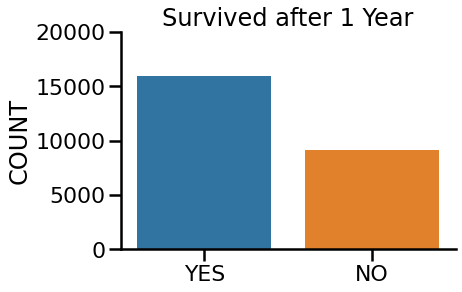

In [28]:
# 'Survived_1_year' as target variable:
sns.set_context("poster", font_scale=1)
ax = sns.countplot(x='Survived_1_year', data=cancer, order = [1,0])
plt.ylim(0, 20000)
sns.despine(top = True, right = True)
ax.set(xticklabels=["YES", "NO"])
ax.set_ylabel("COUNT")
ax.set_xlabel('')
ax.set(title='Survived after 1 Year')
plt.show()

In [29]:
number_survide_patient = len(set(cancer[cancer['Survived_1_year']==1]['Patient_ID']))
number_no_survide_patient = len(set(cancer[cancer['Survived_1_year']==0]['Patient_ID']))

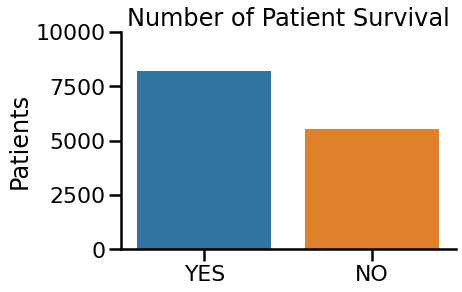

In [30]:
number_survide_patient = len(set(cancer[cancer['Survived_1_year']==1]['Patient_ID']))
number_no_survide_patient = len(set(cancer[cancer['Survived_1_year']==0]['Patient_ID']))
x = ["YES", 'NO']
y = [number_survide_patient, number_no_survide_patient]

ax1 = sns.barplot(x, y)
plt.ylim(0, 10000)
sns.despine(top = True, right = True)
ax1.set(xticklabels=["YES", 'NO'])
ax1.set_ylabel("Patients")
ax1.set_xlabel('')
ax1.set(title='Number of Patient Survival')
plt.show()

# The non_survivors are treated or diagnosed a little bit more.

In [31]:
# Seperate the column_names into numerical and categorical lists: cat and num
column_name = cancer.columns.values.tolist()
print('Column names:', column_name)
cat = []
num = []
for c in column_name:
    if cancer[c].dtype == 'object':
        cat.append(c)
    if cancer[c].dtype == 'int64' or cancer[c].dtype == 'float64':
        num.append(c)
print('Categorical columns:', cat) 
print('Numerical columns:', num)

Column names: ['Diagnosed_Condition', 'Patient_ID', 'Treated_with_drugs', 'Patient_Age', 'Patient_Body_Mass_Index', 'Patient_Smoker', 'Patient_Rural_Urban', 'Patient_mental_condition', 'A', 'B', 'C', 'D', 'E', 'F', 'Z', 'Number_of_prev_cond', 'Survived_1_year', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6']
Categorical columns: ['Treated_with_drugs', 'Patient_Smoker', 'Patient_Rural_Urban', 'Patient_mental_condition']
Numerical columns: ['Diagnosed_Condition', 'Patient_ID', 'Patient_Age', 'Patient_Body_Mass_Index', 'A', 'B', 'C', 'D', 'E', 'F', 'Z', 'Number_of_prev_cond', 'Survived_1_year', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6']


In [32]:
# check if theses are useful variables
print(set(cancer['Z']))
print(len(set(cancer['Diagnosed_Condition'])))

{0.0, 1.0}
53


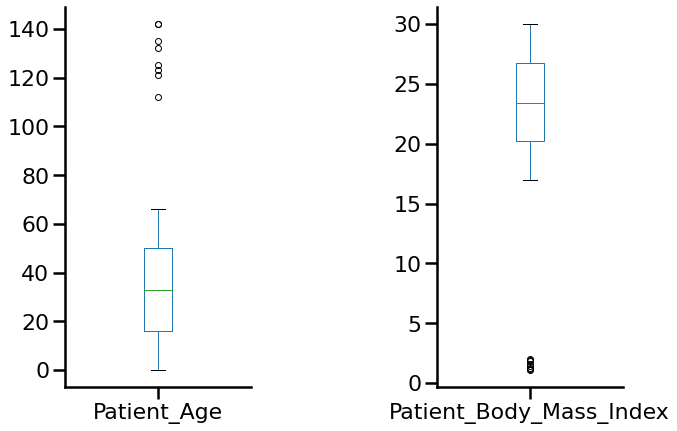

In [33]:
sns.set_context("poster", font_scale=1)
cancer[['Patient_Age', 'Patient_Body_Mass_Index']].plot(kind='box', layout=(1,2), subplots=True, figsize=(10,7))
sns.despine(top = True, right = True)
plt.subplots_adjust(wspace=1,hspace=1); 

In [34]:
len(cancer[cancer['Patient_Age']>100])

8

In [35]:
len(cancer[cancer['Patient_Body_Mass_Index']<5])

8

In [36]:
cancer[cancer['Patient_Age']>100]['Patient_Body_Mass_Index']

cancer[cancer['Patient_Body_Mass_Index']<5]['Patient_Age']

cancer[cancer['Patient_Body_Mass_Index']<5]

,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,...,F,Z,Number_of_prev_cond,Survived_1_year,DX1,DX2,DX3,DX4,DX5,DX6
ID_Patient_Care_Situation,,,,,,,,,,,,,,,,,,,,,
33007,0,12508,0,135,1.4606,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33008,0,12509,0,112,1.2925,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33010,0,12511,0,142,1.5701,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33011,0,12512,0,132,1.9896,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33009,0,12510,0,142,1.1450,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33013,0,12514,0,121,1.0893,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33003,0,12504,0,125,1.8282,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0
33004,0,12505,0,123,1.9290,CANNOTSAY,RURAL,Stable,0.0,0.0,...,0.0,1.0,1.0,1,0,0,0,0,0,0


# These observations need to be removed: After remove theses column 'Z' can be removed also

In [37]:
print (cancer[cancer['Patient_Body_Mass_Index']<5].index)
cancer = cancer.drop(labels=[33007, 33008, 33010, 33011, 33009, 33013, 33003, 33004], axis=0)

cancer = cancer.drop(labels=["Treated_with_drugs", 'Patient_mental_condition','Z'], axis=1)


Int64Index([33007, 33008, 33010, 33011, 33009, 33013, 33003, 33004], dtype='int64', name='ID_Patient_Care_Situation')


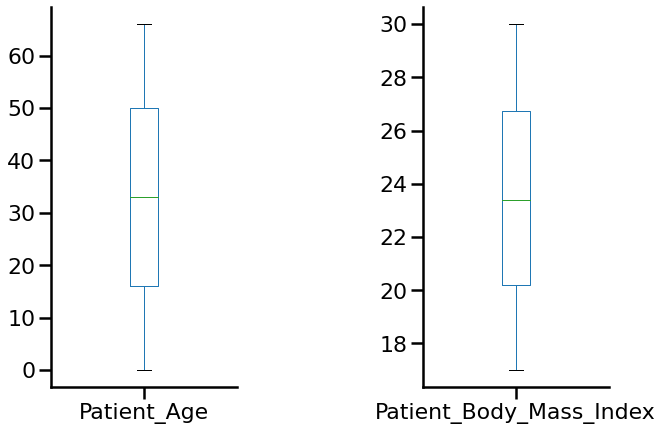

In [38]:
cancer[['Patient_Age', 'Patient_Body_Mass_Index']].plot(kind='box', layout=(1,2), subplots=True, figsize=(10,7))
sns.despine(top = True, right = True)
plt.subplots_adjust(wspace=1,hspace=1);  

## 'Patient_Smoker', 'Patient_Rural_Urban', 'Patient_mental_condition' are categorical

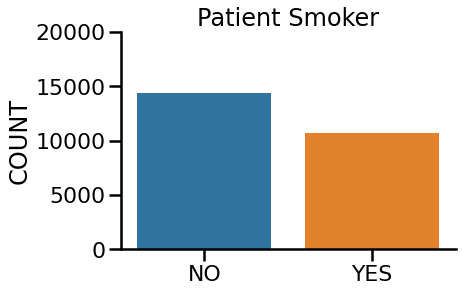

In [39]:
# 'Patient_Smoker' 
sns.set_context("poster", font_scale=1)
ax = sns.countplot(x='Patient_Smoker', data=cancer, order = ['NO', 'YES'])
plt.ylim(0, 20000)
sns.despine(top = True, right = True)
ax.set_ylabel("COUNT")
ax.set_xlabel('')
ax.set(title='Patient Smoker')
plt.show()

In [40]:
# 'Patient_Smoker' by survival
sns.set_context("poster", font_scale=1)
ax = sns.countplot(x='Patient_Smoker', data=cancer, hue='Survived_1_year', order =  ['NO', 'YES'])
plt.ylim(0, 20000)
sns.despine(top = True, right = True)
ax.set_ylabel("COUNT")
ax.set_xlabel('')
ax.set(title='Patient Smoker by Survival')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

SyntaxError: invalid syntax (<ipython-input-40-c2b80486784c>, line 3)

In [ ]:
# 'Patient_Rural_Urban' 
sns.set_context("poster", font_scale=1)
ax = sns.countplot(x='Patient_Rural_Urban', data=cancer)
plt.ylim(0, 20000)
sns.despine(top = True, right = True)
ax.set_ylabel("COUNT")
ax.set_xlabel('')
ax.set(title='Patient Rural Urban')
plt.show()

In [ ]:
# 'Patient_Rural_Urban' 
sns.set_context("poster", font_scale=1)
ax = sns.countplot(x='Patient_Rural_Urban', hue = 'Survived_1_year', data=cancer)
plt.ylim(0, 20000)
sns.despine(top = True, right = True)
ax.set_ylabel("COUNT")
ax.set_xlabel('')
ax.set(title='Patient Rural Urban by Survival')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
sns.set_context("paper")
cancer[['Diagnosed_Condition',  'Patient_Age', 'Patient_Body_Mass_Index', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6', 'A', 'B', 'C', 'D', 'E', 'F', 'Number_of_prev_cond', 'Survived_1_year']].hist(bins = 10, grid=False, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5);

In [ ]:
sns.set_context("poster", font_scale=1)
for column in ['Diagnosed_Condition',  'Patient_Age', 'Patient_Body_Mass_Index', 'Number_of_prev_cond']:
    fig, axs = plt.subplots(2, figsize=(7,5))
    ax[0] = sns.histplot(data=cancer, x=column)
    ax[0].set(title= column)
    ax[1] = sns.histplot(data=cancer, x=column, hue= 'Survived_1_year')
    ax[1].set(title= column + ' by Survival')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labels=['Not', 'Survived'])
    plt.show()

In [ ]:
sns.set_context("poster", font_scale=1)
for column in ['DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6', 'A', 'B', 'C', 'D', 'E', 'F']:
    ax = sns.countplot(x=column, hue = 'Survived_1_year', data=cancer)
    plt.ylim(0, 20000)
    sns.despine(top = True, right = True)
    ax.set_ylabel("COUNT")
    ax.set_xlabel('')
    ax.set(xticklabels=["NO","YES"])
    ax.set(title= column + ' by Survival')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labels=['Not', 'Survived'])
    plt.show()

In [ ]:
sns.set_context("paper", font_scale=1.5)
plt.subplots(figsize=(5,4))
sns.heatmap(cancer[['Diagnosed_Condition',  'Patient_Age', 'Patient_Body_Mass_Index','Number_of_prev_cond']].corr(), annot = True);

In [ ]:
cancer.info()

In [41]:
# Seperate the column_names into numerical and categorical lists: cat and num
print(cancer.columns)
cat = cancer[['Patient_Smoker', 'Patient_Rural_Urban', 'A',
       'B', 'C', 'D', 'E', 'F',
       'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6']]
cancer_cat = pd.get_dummies(cat,drop_first = True)
print(cancer_cat.shape)

Index(['Diagnosed_Condition', 'Patient_ID', 'Patient_Age',
       'Patient_Body_Mass_Index', 'Patient_Smoker', 'Patient_Rural_Urban', 'A',
       'B', 'C', 'D', 'E', 'F', 'Number_of_prev_cond', 'Survived_1_year',
       'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6'],
      dtype='object')
(25071, 14)


In [42]:
cancer_all = pd.concat([cancer_cat, cancer[['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index','Number_of_prev_cond' ]]],axis =1)
cancer_all.shape

(25071, 18)

In [43]:
X = cancer_all
y = cancer['Survived_1_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [44]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"YES":1, "NO":0}

#Creates a reverse dictionary
index_to_class = {1: "YES",  0: "NO"}

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [60]:
X = cancer_all
y = cancer['Survived_1_year']

over = SMOTE(sampling_strategy=1)
X, y = over.fit_resample(X, y)
counter = Counter(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    

X_train.shape

(25440, 18)

## Feature Importance

In [75]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [20, 200],
    'colsample_bytree': [0.2, 0.8],
    'max_depth': [10,50],
    'reg_alpha': [1.1, 1.3],
    'reg_lambda': [1.1, 1.3],
    'subsample': [0.5, 0.9]
}

grid_XG = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False), param_grid=param_grid, cv = 5, scoring='accuracy', verbose=10)
XG_grid_results = grid_XG.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:26:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/64] END colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5; total time=   0.3s
[CV 2/5; 1/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:26:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[CV 1/5; 4/64] END colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.3s
[CV 2/5; 4/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:26:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 4/64] END colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.3s
[CV 3/5; 4/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:26:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logl

[CV 2/5; 7/64] END colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.3s
[CV 3/5; 7/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:26:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 7/64] END colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.3s
[CV 4/5; 7/64] START colsample_bytree=0.2, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:26:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logl

[CV 3/5; 10/64] END colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   2.2s
[CV 4/5; 10/64] START colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:26:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 10/64] END colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   2.2s
[CV 5/5; 10/64] START colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:26:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 4/5; 13/64] END colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   2.2s
[CV 5/5; 13/64] START colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5
[11:27:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 13/64] END colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   2.1s
[CV 1/5; 14/64] START colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9
[11:27:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 5/5; 16/64] END colsample_bytree=0.2, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.3, subsample=0.9; total time=   2.2s
[CV 1/5; 17/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:28:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 17/64] END colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5; total time=   0.3s
[CV 2/5; 17/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:28:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

[CV 1/5; 20/64] END colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.4s
[CV 2/5; 20/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:28:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 20/64] END colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.3s
[CV 3/5; 20/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:28:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 2/5; 23/64] END colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.3s
[CV 3/5; 23/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:28:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 23/64] END colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.3s
[CV 4/5; 23/64] START colsample_bytree=0.2, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:28:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 3/5; 26/64] END colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   3.1s
[CV 4/5; 26/64] START colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:28:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 26/64] END colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   3.4s
[CV 5/5; 26/64] START colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:28:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 4/5; 29/64] END colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   2.5s
[CV 5/5; 29/64] START colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5
[11:29:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 29/64] END colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   2.5s
[CV 1/5; 30/64] START colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9
[11:29:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 5/5; 32/64] END colsample_bytree=0.2, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.3, subsample=0.9; total time=   3.1s
[CV 1/5; 33/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 33/64] END colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5; total time=   0.7s
[CV 2/5; 33/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

[CV 1/5; 36/64] END colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.8s
[CV 2/5; 36/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:30:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 36/64] END colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   0.8s
[CV 3/5; 36/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 2/5; 39/64] END colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.7s
[CV 3/5; 39/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:30:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 39/64] END colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   0.7s
[CV 4/5; 39/64] START colsample_bytree=0.8, max_depth=10, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:30:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 3/5; 42/64] END colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   6.9s
[CV 4/5; 42/64] START colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:31:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 42/64] END colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   7.1s
[CV 5/5; 42/64] START colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:31:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 4/5; 45/64] END colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   6.4s
[CV 5/5; 45/64] START colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5
[11:33:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 45/64] END colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   6.3s
[CV 1/5; 46/64] START colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9
[11:33:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 5/5; 48/64] END colsample_bytree=0.8, max_depth=10, n_estimators=200, reg_alpha=1.3, reg_lambda=1.3, subsample=0.9; total time=   7.0s
[CV 1/5; 49/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:35:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 49/64] END colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5; total time=   1.3s
[CV 2/5; 49/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.1, subsample=0.5
[11:35:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

[CV 1/5; 52/64] END colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   1.4s
[CV 2/5; 52/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:35:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 52/64] END colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9; total time=   1.4s
[CV 3/5; 52/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.1, reg_lambda=1.3, subsample=0.9
[11:35:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 2/5; 55/64] END colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   1.2s
[CV 3/5; 55/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:35:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 55/64] END colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5; total time=   1.0s
[CV 4/5; 55/64] START colsample_bytree=0.8, max_depth=50, n_estimators=20, reg_alpha=1.3, reg_lambda=1.3, subsample=0.5
[11:35:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

[CV 3/5; 58/64] END colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   9.7s
[CV 4/5; 58/64] START colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:37:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 58/64] END colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9; total time=   9.8s
[CV 5/5; 58/64] START colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.1, reg_lambda=1.1, subsample=0.9
[11:37:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 4/5; 61/64] END colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   7.8s
[CV 5/5; 61/64] START colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5
[11:39:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 61/64] END colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.5; total time=   8.3s
[CV 1/5; 62/64] START colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9
[11:39:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

[CV 5/5; 64/64] END colsample_bytree=0.8, max_depth=50, n_estimators=200, reg_alpha=1.3, reg_lambda=1.3, subsample=0.9; total time=  12.7s
[12:39:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3167
           1       0.87      0.88      0.88      3193

    accuracy                           0.87      6360
   macro avg       0.87      0.87      0.87      6360
weighted avg       0.87      0.87      0.87      6360



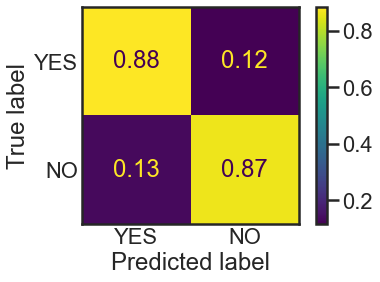

In [76]:
best_clf = grid_XG.best_estimator_
y_pred = best_clf.predict(X_test)

y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

print(classification_report(y_test, y_pred))

y_unique = ["YES",'NO']
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(False)
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.labelleft'] = True

[11:24:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3167
           1       0.87      0.88      0.88      3193

    accuracy                           0.88      6360
   macro avg       0.88      0.87      0.87      6360
weighted avg       0.88      0.88      0.87      6360



NameError: name 'false' is not defined

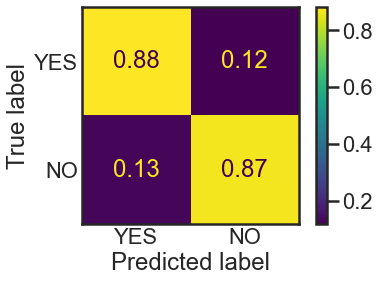

In [72]:
#print(grid_GX.best_params_)
import xgboost as xgb
XG = xgb.XGBClassifier(use_label_encoder=False, colsample_bytree=0.8, max_depth=50, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample = 0.9)
XG.fit(X_train, y_train)
y_pred = XG.predict(X_test)

y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

print(classification_report(y_test, y_pred))

y_unique = ["YES",'NO']
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(False)
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.labelleft'] = True

0.9530646600141947


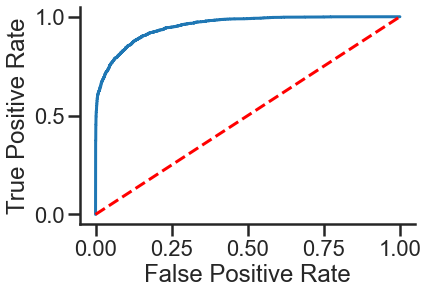

In [68]:
y_pred_proba = XG.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr)
x = np.linspace(0,1,100)
y = x
plt.plot(x, y, '--r', label='Random Guess')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
sns.despine()
plt.show()

[0.07431449 0.02984419 0.02647037 0.08708757 0.02182019 0.01324765
 0.05605813 0.05179721 0.08447523 0.05823779 0.18733247 0.08628371
 0.1207317  0.024733   0.02184261 0.01474996 0.01878116 0.02219253]
18


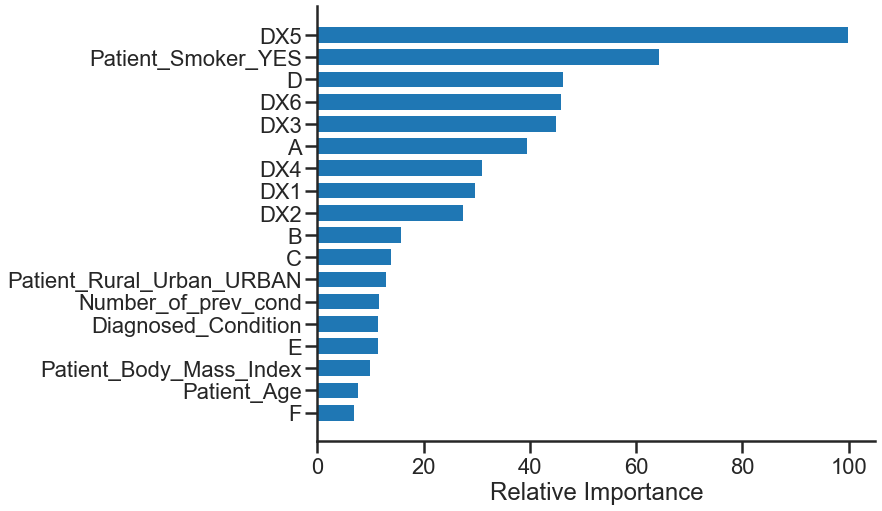

In [70]:
sns.set_style("ticks")

feature_importance = XG.feature_importances_
print(feature_importance)
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0])
print(pos.size)
sorted_idx.size

plt.figure(figsize=(10,8))


plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.labelleft'] = True
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
sns.despine(right = True, top = True)
plt.grid(False)
plt.show()